In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!rocm-smi

/bin/bash: line 1: rocm-smi: command not found


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
df = pd.read_csv("tips.csv")
df.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [6]:
df.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


<Axes: xlabel='total_bill', ylabel='Count'>

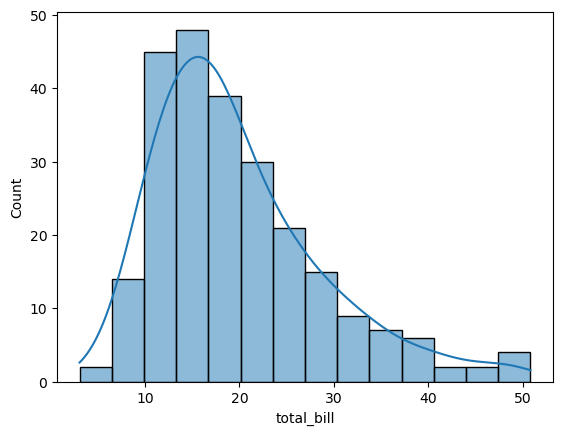

In [7]:
sns.histplot(df["total_bill"],kde=True)

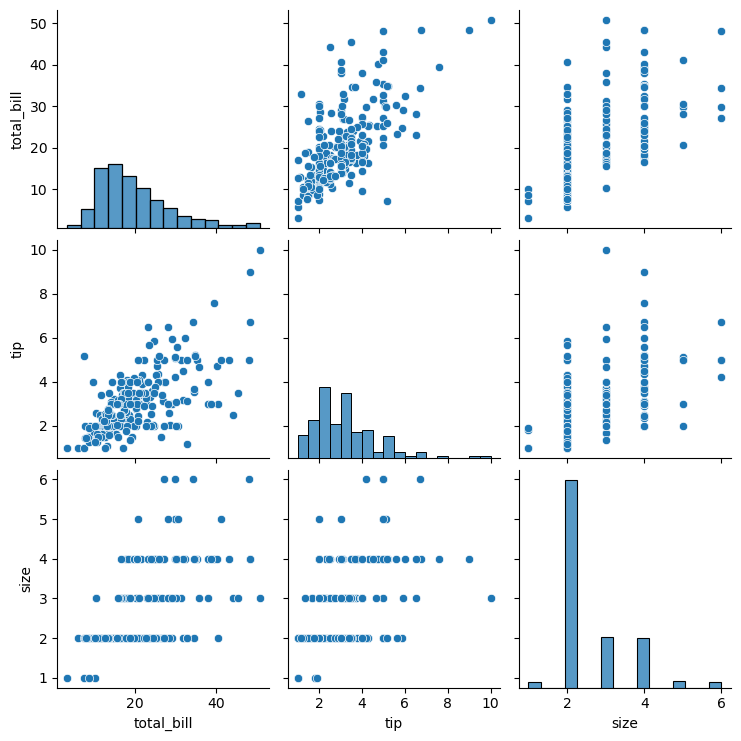

In [8]:
sns.pairplot(df)

In [9]:
df.columns

Index(['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size'], dtype='object')

In [10]:
X = df.drop('tip',axis=1)
Y = df['tip']

In [11]:
X.head(5)

,total_bill,sex,smoker,day,time,size
0,16.99,Female,No,Sun,Dinner,2
1,10.34,Male,No,Sun,Dinner,3
2,21.01,Male,No,Sun,Dinner,3
3,23.68,Male,No,Sun,Dinner,2
4,24.59,Female,No,Sun,Dinner,4


In [12]:
X.tail(5)

,total_bill,sex,smoker,day,time,size
239,29.03,Male,No,Sat,Dinner,3
240,27.18,Female,Yes,Sat,Dinner,2
241,22.67,Male,Yes,Sat,Dinner,2
242,17.82,Male,No,Sat,Dinner,2
243,18.78,Female,No,Thur,Dinner,2


In [13]:
X['day'].unique()

array(['Sun', 'Sat', 'Thur', 'Fri'], dtype=object)

In [14]:
from sklearn.preprocessing import LabelEncoder
Le = LabelEncoder()

In [15]:
for i in X.columns:
    if X[i].dtype == 'object':
        X[i] = Le.fit_transform(X[i])
X.tail(5)

,total_bill,sex,smoker,day,time,size
239,29.03,1,0,1,0,3
240,27.18,0,1,1,0,2
241,22.67,1,1,1,0,2
242,17.82,1,0,1,0,2
243,18.78,0,0,3,0,2


In [16]:
X['day'].unique()

array([2, 1, 3, 0])

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
X_train = torch.Tensor(X_train.values).to(device)
Y_train = torch.Tensor(Y_train.values).to(device)
X_test = torch.Tensor(X_test.values).to(device)
Y_test = torch.Tensor(Y_test.values).to(device)

In [20]:
class LinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        out = self.linear(x)
        return out

In [21]:
model = LinearRegression(X_train.shape[1])
model.to(device)

LinearRegression(
  (linear): Linear(in_features=6, out_features=1, bias=True)
)

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
import os
os.environ['AMD_SERIALIZE_KERNEL'] = '3'
os.environ['TORCH_USE_HIP_DSA'] = '1'

In [24]:
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch[{epoch+1}/{100}], loss: {loss.item():.4f}')

RuntimeError: The size of tensor a (195) must match the size of tensor b (49) at non-singleton dimension 0

In [ ]:
torch.__version__

'2.3.0+rocm6.0'

In [25]:
X_train

tensor([[13.2800,  1.0000,  0.0000,  1.0000,  0.0000,  2.0000],
        [24.2700,  1.0000,  1.0000,  1.0000,  0.0000,  2.0000],
        [27.2800,  1.0000,  1.0000,  0.0000,  0.0000,  2.0000],
        ...,
        [ 5.7500,  0.0000,  1.0000,  0.0000,  0.0000,  2.0000],
        [34.6300,  1.0000,  1.0000,  2.0000,  0.0000,  2.0000],
        [44.3000,  0.0000,  1.0000,  1.0000,  0.0000,  3.0000]])

In [27]:
Y_train

tensor([[19.8200,  1.0000,  0.0000,  1.0000,  0.0000,  2.0000],
        [ 8.7700,  1.0000,  0.0000,  2.0000,  0.0000,  2.0000],
        [24.5500,  1.0000,  0.0000,  2.0000,  0.0000,  4.0000],
        [25.8900,  1.0000,  1.0000,  1.0000,  0.0000,  4.0000],
        [13.0000,  0.0000,  1.0000,  3.0000,  1.0000,  2.0000],
        [17.8900,  1.0000,  1.0000,  2.0000,  0.0000,  2.0000],
        [28.4400,  1.0000,  1.0000,  3.0000,  1.0000,  2.0000],
        [12.4800,  0.0000,  0.0000,  3.0000,  1.0000,  2.0000],
        [14.7800,  1.0000,  0.0000,  2.0000,  0.0000,  2.0000],
        [15.3800,  0.0000,  1.0000,  0.0000,  0.0000,  2.0000],
        [18.2900,  1.0000,  0.0000,  2.0000,  0.0000,  2.0000],
        [10.7700,  1.0000,  0.0000,  1.0000,  0.0000,  2.0000],
        [10.6500,  0.0000,  0.0000,  3.0000,  1.0000,  2.0000],
        [14.4800,  1.0000,  1.0000,  2.0000,  0.0000,  2.0000],
        [10.0700,  0.0000,  0.0000,  3.0000,  1.0000,  1.0000],
        [18.6400,  0.0000,  0.0000,  3.0

In [28]:
X_test

tensor([ 2.7200,  2.0300,  4.0000,  4.5000,  2.0300,  3.5100,  2.0000,  5.1500,
         1.7500,  2.7400,  3.0000,  5.1400,  3.5000,  5.6500,  2.5000,  2.0100,
         4.0800,  2.0900,  1.0000,  3.4100,  3.4800,  2.0000,  3.0000,  2.7100,
         3.0000,  3.0000,  3.0000,  3.6800,  4.7100,  3.0000,  4.2000,  1.7300,
         4.0000,  3.1500,  1.5000,  3.0000,  2.0000,  2.5000,  1.5700,  3.6000,
         4.3000,  3.0600,  5.9200,  1.4800,  4.3000,  3.0000,  2.6000,  4.7300,
         3.5000,  4.0000,  3.0800,  2.5400,  3.7600,  3.0000,  3.0000,  2.3000,
         2.0000,  1.2500,  2.5000,  6.5000,  2.0200,  1.0100,  3.5000,  4.0000,
         5.0000,  2.5000,  2.0000,  1.6300,  3.1100,  3.0000,  5.1700, 10.0000,
         2.5000,  3.0000,  2.0000,  5.0000,  2.0000,  2.2300,  1.8000,  2.6100,
         2.0000,  5.0000,  4.6700,  2.0000,  2.5000,  3.6100,  2.5000,  3.0000,
         6.7000,  3.1800,  2.0000,  1.9800,  1.2500,  2.0000,  2.2000,  3.0000,
         1.9700,  3.2300,  2.6400,  5.60

In [29]:
Y_test

tensor([3.1800, 2.0000, 2.0000, 5.1600, 2.0000, 2.0000, 2.5600, 2.5200, 3.2300,
        3.0000, 3.0000, 1.4700, 1.5000, 2.0000, 1.8300, 1.3600, 4.0000, 3.9200,
        2.4700, 5.0000, 2.4500, 3.3500, 4.0000, 1.4500, 3.5000, 2.3100, 1.7100,
        5.0000, 2.0000, 5.0000, 4.0000, 1.4400, 2.3400, 3.2100, 3.5000, 2.9200,
        1.5000, 5.0000, 2.7500, 2.0000, 1.2500, 2.0000, 2.5500, 1.6700, 2.0000,
        1.0000, 1.6100, 2.3100, 1.4400])